In [2]:
# measure n(z)
import yaw

In [3]:
# check
import numpy as np
from astropy.io import fits
import pylab as pl

In [4]:
import healpy as hp

In [5]:
fin = fits.open("/export/donatello/qhang/nersc/lya/delta-noisy-desi-footprint.fits")

In [5]:
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =              5164256 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

In [6]:
ra = fin[1].data['RA']
dec = fin[1].data['DEC'] # in rad

In [7]:
z = fin[1].data['Z'][::100]
uz = np.unique(z)
print(len(uz))

print(uz)

dz = uz[1]-uz[0]
zbin_edges = np.append(uz - dz/2, uz[-1]+dz/2)
zbin_edges

18
[1.94030859 1.99758565 2.05486271 2.11213977 2.16941683 2.22669389
 2.28397095 2.34124801 2.39852507 2.45580213 2.51307919 2.57035625
 2.62763331 2.68491037 2.74218743 2.79946449 2.85674155 2.91401861]


array([1.91167006, 1.96894712, 2.02622418, 2.08350124, 2.1407783 ,
       2.19805536, 2.25533242, 2.31260948, 2.36988654, 2.4271636 ,
       2.48444066, 2.54171772, 2.59899478, 2.65627184, 2.7135489 ,
       2.77082596, 2.82810302, 2.88538008, 2.94265714])

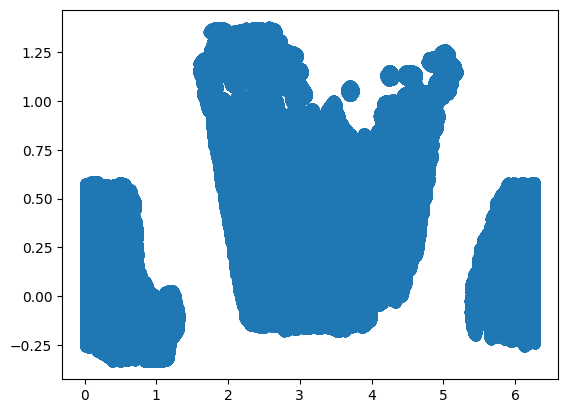

In [7]:
pl.scatter(ra, dec)

In [8]:
# let's create a sample in the overlap footprint
mask = hp.read_map("/export/donatello/qhang/nersc/lya/desixlsst-mask-nside-128.fits")
nside= hp.get_nside(mask)
print(nside)
usepix = np.arange(int(12*nside**2))[mask.astype(bool)]

128


In [37]:
pix = hp.ang2pix(nside, ra*180/np.pi, dec*180/np.pi, nest=False, lonlat=True)
ind = np.isin(pix, usepix)
print(len(ind), sum(ind))

NameError: name 'ra' is not defined

In [14]:
use_cat = {}
cols = ['RA','DEC','Z','ZQSO','DELTA_F','WEIGHTS']
for key in cols:
    if key != 'WEIGHTS':
        use_cat[key] = (fin[1].data[key])[ind]
    elif key == 'WEIGHTS':
        use_cat[key] = (fin[1].data['TOTWEIGHTS'] / fin[1].data['NPIX'])[ind]  

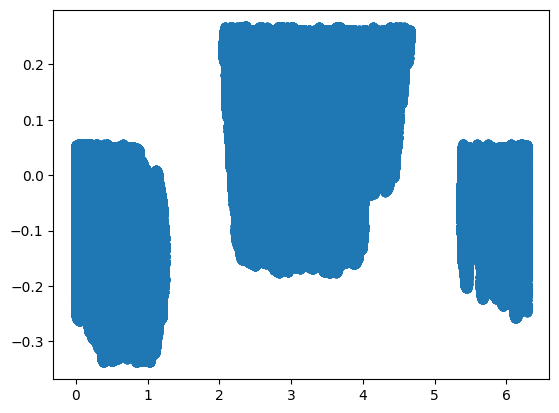

In [15]:
pl.scatter(use_cat['RA'], use_cat['DEC'])

In [52]:
# save use_cat:
def save_fits_data(data, columns, output_name):
    """Take the output of the GCR and save it to fits format.
    
    Parameters
    ----------
    data : `dict` of array-likes
        Catalog data to store.
    columns : `list` of `str`s
        String names of catalog columns to create in the fits table
        and copy from the input `data`.
    output_name : `str`
        Full path name of the new file to write to.
    """

    dtype_to_fits_type = {'int64': 'K',
                          'float64': 'D',
                          'float32': 'E',
                          '<U6': '20A',
                          'bool': 'bool',
                          '>f8': 'D',
                          '>f4': 'E',
                         }
    fits_columns = []
    for col in columns:
        fits_columns.append(fits.Column(name=col, array=data[col],
                                        format=dtype_to_fits_type[str(data[col].dtype)]))
    output = fits.BinTableHDU.from_columns(fits_columns)
    
    output.writeto(output_name, overwrite=True)

In [16]:
output_name = "/export/donatello/qhang/nersc/lya/delta-noisy-overlap-footprint.fits"
save_fits_data(use_cat, cols, output_name)

In [11]:
cache_dir = "/export/donatello/qhang/nersc/lya/yaw_cache"  # create as needed
reference_path = "/export/donatello/qhang/nersc/lya/delta-noisy-overlap-footprint.fits"
unknown_path = "/export/donatello/qhang/nersc/lya/photometry-catalogue-overlap-zmin-1.8.fits"
unknown_rand_path = "/export/donatello/qhang/nersc/lya/random-overlap-footprint.fits"

In [8]:
! rm -r /export/donatello/qhang/nersc/lya/yaw_cache/*

Illegal variable name.


In [23]:
fin = fits.open(unknown_path)
print(len(fin[1].data['RA']))
print(fin[1].data['DEC'].min(), fin[1].data['DEC'].max())

110938487
-20.421877 15.403299


In [9]:
patch_num = 64

cat_reference = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/reference",
    path=reference_path,
    ra_name="RA",
    dec_name="DEC",
    kappa_name="DELTA_F",
    weight_name="WEIGHTS",  # optional
    redshift_name="Z",  # required for reference
    #patch_centers=patch_centers,  # use previously computed centers
    # patch_name=None,
    patch_num=patch_num,
    degrees=False,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

# extract the patch centers to use these for all following catalogs
patch_centers = cat_reference.get_centers()

processed 1/1 (100%) t=0m00.82s
processed 64/64 (100%) t=0m00.29s


In [10]:
cat_unknown = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/unknown",
    path=unknown_path,
    ra_name="RA",
    dec_name="DEC",
    #weight_name="weight_column_name",  # optional
    # we don't know the redshifts here, so we skip the argument
    patch_centers=patch_centers,  # use previously computed centers
    # patch_name=None,
    # patch_num=None,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

cat_ref_rand = None
#cat_unk_rand = None  # would be constructed same as cat_unknown

processed 7/7 (100%) t=0m18.52s
processed 64/64 (100%) t=0m04.68s


In [11]:
cat_unk_rand = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/unk_rand",
    path=unknown_rand_path,
    ra_name="RA",
    dec_name="DEC",
    #weight_name="weight_column_name",  # optional
    # we don't know the redshifts here, so we skip the argument
    patch_centers=patch_centers,  # use previously computed centers
    # patch_name=None,
    # patch_num=None,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

processed 8/8 (100%) t=0m25.21s
processed 64/64 (100%) t=0m05.95s


In [12]:
config = yaw.Configuration.create(
    rmin=1,  # can also be a list of lower scale limits
    rmax=10, # can also be a list of upper scale limits
    unit="arcmin",  # defaults to angular diameter distance, but angles and
                  # comoving transverse distance are supported
    # rweight=None,     # if you want to weight pairs by scales
    # resolution=None,  # resolution of weights in no. of log-scale bins
    #zmin=0.1,
    #zmax=1.2,
    #num_bins=22,
    # method="linear",
    edges=zbin_edges,  # provide your custom bin edges
)

In [13]:
from yaw.correlation import autocorrelate_scalar, crosscorrelate_scalar

In [14]:
cts_ss_list = autocorrelate_scalar(
    config,
    cat_reference,
    progress=True,  # shows a progress bar, default: False
)

processed 64/64 (100%) t=0m00.59s
processed 206/206 (100%) t=0m01.23s
processed 206/206 (100%) t=0m01.25s


In [15]:
cts_ss = cts_ss_list[0]
cts_ss.to_file("w_ss.hdf5")

Text(0, 0.5, '$\\delta F$ auto-correlation')

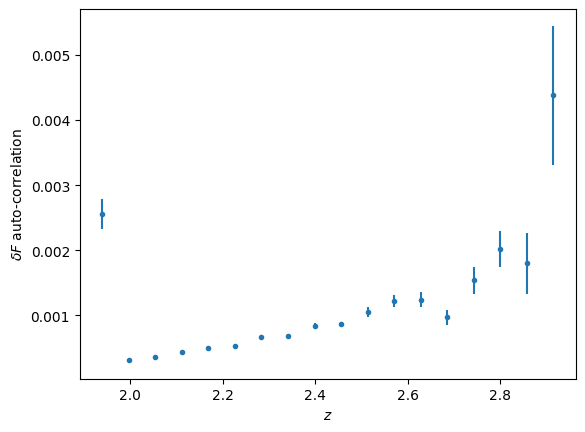

In [29]:
cts_ss.sample().plot()
pl.xlabel("$z$")
pl.ylabel("$\\delta F$ auto-correlation")

In [17]:
cts_sp_list = crosscorrelate_scalar(
    config,
    cat_reference,
    cat_unknown,
    unk_rand=cat_unk_rand,
    progress=True,  # shows a progress bar, default: False
)

processed 64/64 (100%) t=0m00.20s
processed 64/64 (100%) t=0m17.79s
processed 64/64 (100%) t=0m33.17s
processed 364/364 (100%) t=2m20.47s
processed 364/364 (100%) t=2m20.23s
processed 364/364 (100%) t=3m03.30s
processed 364/364 (100%) t=3m12.07s


In [18]:
cts_sp = cts_sp_list[0]
cts_sp.to_file("w_sp.hdf5")
# restored = yaw.CorrFunc.from_file("w_sp.hdf5")

In [19]:
cts_sp.sample().data

array([-1.44053052e-05, -6.24057489e-05, -6.86444777e-05, -9.66709439e-05,
       -8.37572331e-05, -1.39566140e-04, -1.75801283e-04, -7.71328516e-05,
       -1.42063623e-04, -1.22640491e-04, -1.32634865e-04, -1.24489448e-04,
       -2.94686166e-04, -1.86892010e-04,  2.08137415e-05, -3.61890781e-04,
       -1.33300324e-04, -3.08668592e-04])

In [21]:
# with no random:
cts_sp_list_norand = crosscorrelate_scalar(
    config,
    cat_reference,
    cat_unknown,
    unk_rand=None,
    progress=True,  # shows a progress bar, default: False
)

processed 64/64 (100%) t=0m00.23s
processed 64/64 (100%) t=0m00.20s
processed 364/364 (100%) t=2m23.81s
processed 364/364 (100%) t=2m20.43s


In [22]:
cts_sp_norand = cts_sp_list_norand[0]
cts_sp_norand.to_file("w_sp_norand.hdf5")
# restored = yaw.CorrFunc.from_file("w_sp.hdf5")

Text(0, 0.5, '$\\delta_F$ - galaxy cross-correlation')

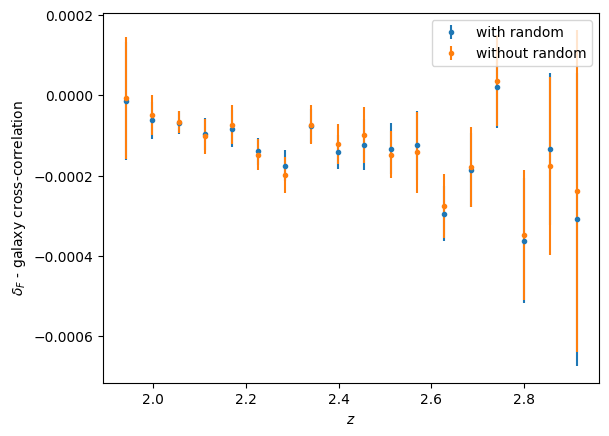

In [28]:
cts_sp.sample().plot(label="with random")
cts_sp_norand.sample().plot(label="without random")
pl.legend()
pl.xlabel("$z$")
pl.ylabel("$\\delta_F$ - galaxy cross-correlation")

In [30]:
ncc = yaw.RedshiftData.from_corrfuncs(
    cross_corr=cts_sp,
    ref_corr=cts_ss,
    # unk_corr=None,
)

<Axes: >

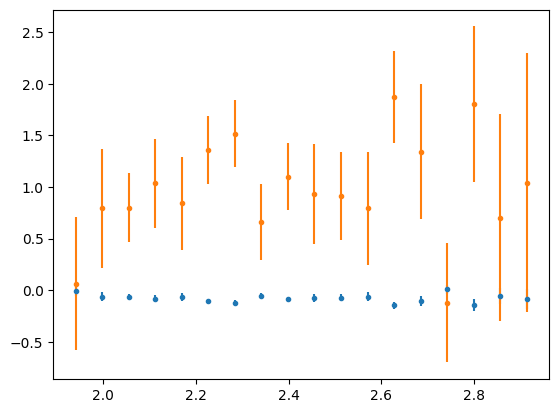

In [31]:
ncc.plot(
    # label=None,
    # ax=None,  # plot to specific matplotlib axis
    # ...
)

# or even with estimated normalisation
ncc.normalised().plot()

# cross validation with tree corr

In [9]:
import treecorr

In [12]:
fin = fits.open(reference_path)
ra = fin[1].data['RA']
dec = fin[1].data['DEC']
Z = fin[1].data['Z']
deltaf = fin[1].data['DELTA_F']
w = fin[1].data['WEIGHTS']

In [13]:
# define this in bins:
CAT_REF = {}

for ii in range(len(zbin_edges)-1):
    ind = (Z>zbin_edges[ii])&(Z<=zbin_edges[ii+1])
    CAT_REF[ii] = treecorr.Catalog(ra=ra[ind], dec=dec[ind], 
                           k=deltaf[ind], w=w[ind],
                       ra_units='radians', dec_units='radians')

In [14]:
print(len(CAT_REF))

18


In [11]:
cat_unknown = treecorr.Catalog(unknown_path, ra_col='RA', dec_col='DEC', 
                       ra_units='degrees', dec_units='degrees')

In [21]:
# measure the correlation:
XI = np.zeros(len(zbin_edges)-1)
nk = treecorr.NKCorrelation(min_sep=1., max_sep=10., nbins=1, sep_units='arcmin')
for ii in range(len(zbin_edges)-1):
    nk.process(cat_unknown,CAT_REF[ii])   # Compute the cross-correlation function.     # Write out to a file.
    XI[ii] = nk.xi


/tmp/ipykernel_3417163/1902526379.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  XI[ii] = nk.xi


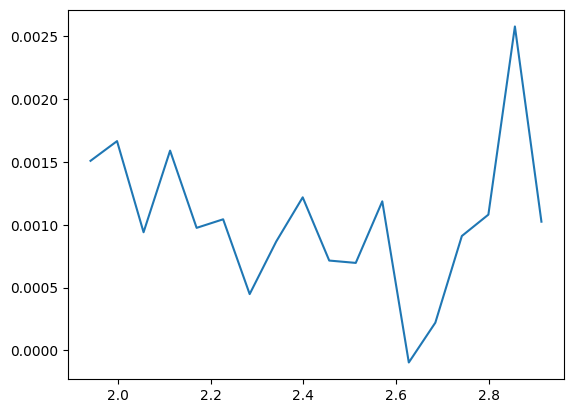

In [24]:
# plot them:
meanz = (zbin_edges[1:] + zbin_edges[:-1])/2.
pl.plot(meanz, XI)
if(1):
    np.savetxt("treecorr-nk.txt", np.c_[meanz, XI])

In [16]:
# load random and select 10% of the objects:

cat_rand = treecorr.Catalog(unknown_rand_path, ra_col='RA', dec_col='DEC', 
                       ra_units='degrees', dec_units='degrees', every_nth=10)
print(cat_rand.ntot)

13309998


In [17]:
# measure the correlation:
XI_rand = np.zeros(len(zbin_edges)-1)
nk = treecorr.NKCorrelation(min_sep=1., max_sep=10., nbins=1, sep_units='arcmin')
for ii in range(len(zbin_edges)-1):
    print(f"Working on {ii+1}/18")
    nk.process(cat_rand,CAT_REF[ii])   # Compute the cross-correlation function.     # Write out to a file.
    XI_rand[ii] = nk.xi

Working on 1/18
Working on 2/18


/tmp/ipykernel_3900191/3220507556.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  XI_rand[ii] = nk.xi


Working on 3/18
Working on 4/18
Working on 5/18
Working on 6/18
Working on 7/18
Working on 8/18
Working on 9/18
Working on 10/18
Working on 11/18
Working on 12/18
Working on 13/18
Working on 14/18
Working on 15/18
Working on 16/18
Working on 17/18
Working on 18/18


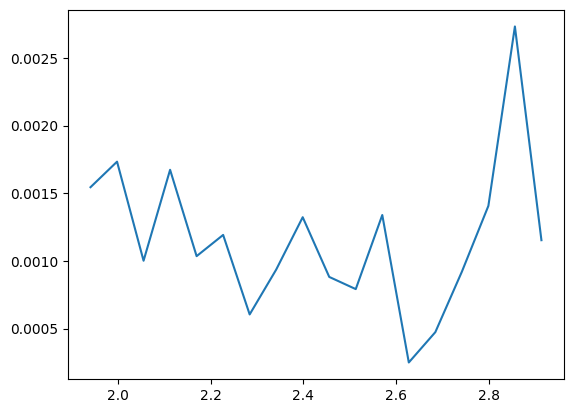

In [19]:
# plot them:
meanz = (zbin_edges[1:] + zbin_edges[:-1])/2.
pl.plot(meanz, XI_rand)
if(1):
    np.savetxt("treecorr-nk-rand.txt", np.c_[meanz, XI_rand])

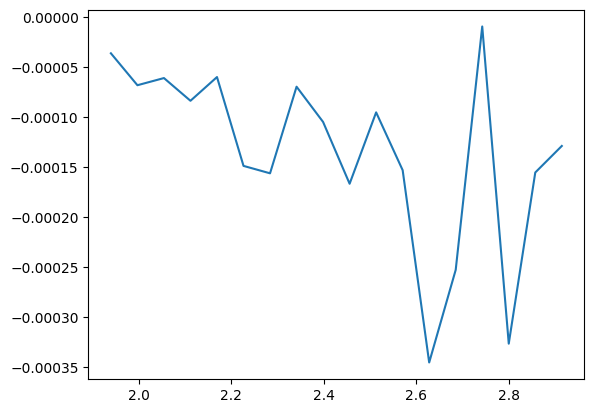

In [22]:
# load the results:

nk = np.loadtxt('treecorr-nk.txt')
nk_rand = np.loadtxt('treecorr-nk-rand.txt')

pl.plot(nk[:,0], nk[:,1]-nk_rand[:,1], label='nk - rk')

In [29]:
# load yaw results:
from yaw.correlation.corrfunc import ScalarCorrFunc

cts_sp = ScalarCorrFunc.from_file("w_sp.hdf5")

KeyError: "Unable to synchronously open object (object 'counts' doesn't exist)"

# generate random

In [49]:
nrandom = int(1e8)
declim = np.array([-22, 17])

RA_rand = np.array([])
DEC_rand = np.array([])

for ii in range(10):
    ra_rand = np.random.uniform(0,360, nrandom)
    dec_rand = 2*np.random.uniform(0,1, nrandom)-1
    dec_rand = np.arccos(dec_rand)*180/np.pi-90

    pix = hp.ang2pix(nside, ra_rand, dec_rand, lonlat=True)
    useind = np.isin(pix, usepix)

    ra_rand = ra_rand[useind]
    dec_rand = dec_rand[useind]
    
    RA_rand=np.append(RA_rand, ra_rand)
    DEC_rand=np.append(DEC_rand, dec_rand)

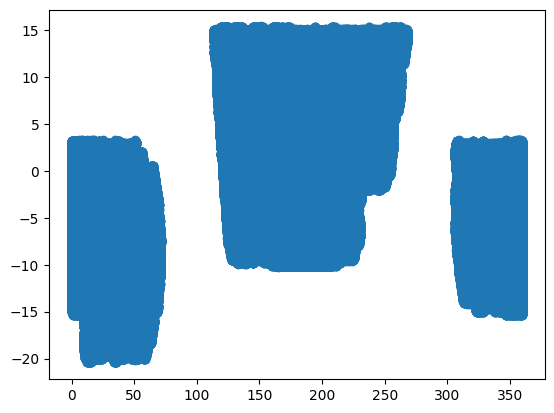

In [46]:
pl.scatter(ra_rand, dec_rand)

In [47]:
print(len(ra_rand)/nrandom)

0.1331237


In [50]:
print(len(RA_rand))

133099972


In [53]:
# save the catalogue:
output_name = "/export/donatello/qhang/nersc/lya/random-overlap-footprint.fits"
save_fits_data({'RA': RA_rand, 'DEC': DEC_rand}, ['RA','DEC'], output_name)

In [54]:
! du -sh /export/donatello/qhang/nersc/lya/random-overlap-footprint.fits

Illegal variable name.
2.0G	/export/donatello/qhang/nersc/lya/random-overlap-footprint.fits
